In [ ]:
from functions.data_loader import processDFA1
from functions._utils_ import *
import os
import sys

# Go up one directory level to reach root
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

# Add root to Python path
sys.path.insert(0, root_dir)

print(f"Current working directory: {os.getcwd()}")
print(f"Root directory added to path: {root_dir}")


CURRENT_DIR

'/mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui'

In [2]:
models_dir = os.path.join(CURRENT_DIR, "models")
models = {}

for file in os.listdir(models_dir):
    if file.endswith(".onnx"):
        key = file.split("_")[0]  # Take index 0 after splitting by "_"
        models[key] = {
            "model_path": os.path.join(models_dir, file),
            "meta_path": os.path.join(models_dir, file.replace(".onnx", ".json"))
        }

In [3]:
region = (600, 1500)  # Raman region of interest
labels = ["benign", "cancer"]
# https://ramanspy.readthedocs.io/en/latest/preprocessing.html
# https://www.nature.com/articles/s41377-024-01394-5
preprocess_steps_test = [
    rp.preprocessing.misc.Cropper(region=region),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=11, polyorder=3),
    # rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.baseline.ModPoly(tol=0.001),
    # rp.preprocessing.normalise.Vector(),
    SNV()   # Use SNV normalization as in the Readme
]

In [4]:
# https://datadryad.org/dataset/doi:10.5061/dryad.cjsxksn3p
PROSTATE_CANCER_DATASET_PATH = os.path.join(
    CURRENT_DIR,
    "test_rawdata",
    "A1-dataset_prostate_cancer",
    "Benign_vs_Cancer.pkl",
)

load_dataset = RamanDataLoader(PROSTATE_CANCER_DATASET_PATH)
rawdata = load_dataset.data

# create a subset for a given key value
chum_df = rawdata[rawdata['Cohort'] == 'CHUM']
uhn_df = rawdata[rawdata['Cohort'] == 'UHN']
chuq_df = rawdata[rawdata['Cohort'] == 'CHUQc-UL']
print(rawdata.shape, chum_df.shape, uhn_df.shape, chuq_df.shape)

Loaded Raman spectra with 4 samples and 4220 data points
(4220, 5) (1484, 5) (1014, 5) (1722, 5)


In [5]:
chumDF_benign = RamanPipeline().preprocess(
    dfs=[processDFA1(chum_df[chum_df['Label'] == 'Benign'])],
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

chumDF_cancer = RamanPipeline().preprocess(
    dfs=[processDFA1(chum_df[chum_df['Label'] == 'Cancer'])],
    label=labels[1],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [6]:
uhnDF_benign = RamanPipeline().preprocess(
    dfs=[processDFA1(uhn_df[uhn_df['Label'] == 'Benign'])],
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

uhnDF_cancer = RamanPipeline().preprocess(
    dfs=[processDFA1(uhn_df[uhn_df['Label'] == 'Cancer'])],
    label=labels[1],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [7]:
chuqDF_benign = RamanPipeline().preprocess(
    dfs=[processDFA1(chuq_df[chuq_df['Label'] == 'Benign'])],
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

chuqDF_cancer = RamanPipeline().preprocess(
    dfs=[processDFA1(chuq_df[chuq_df['Label'] == 'Cancer'])],
    label=labels[1],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [8]:
hirushu_dir = CURRENT_DIR + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'
hirushu_dir

normal_dfs = []
window_size = 50
for k in range(1, 4):
    csv_path = os.path.join(
        hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'normal', 'normal.csv')
    loader = RamanDataLoader(csv_path)
    df = loader.data
    processor = RamanNoiseProcessor(df)
    processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
    normal_dfs.append(processed_df)

# Process Hirushu data
hirushu_benign = RamanPipeline().preprocess(
    dfs=normal_dfs,
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

Loaded Raman spectra with 19 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 49 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 39 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹


In [9]:
cancer_spectra = [uhnDF_cancer, chuqDF_cancer]
benign_spectra = [uhnDF_benign, chuqDF_benign]
test_spectra = [k["processed"] for k in cancer_spectra + benign_spectra]
true_labels = []
for k in cancer_spectra + benign_spectra:
    true_labels.extend(k["labels"])

In [10]:
# for model in models:
#     print(f"Loading {model} model...")
#     model = models[model]
#     svc_linear_onnx = MLModel(onnx_path=model["model_path"],
#                                 meta_path=model["meta_path"],)
#     break

# if svc_linear_onnx.load_success:
#     pred = svc_linear_onnx.predict(test_spectra, class_labels=labels)

/home/zerozed/coding-j/研究/real-time-raman-spectral-classifier-with-gui/.conda/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-05-22 16:58:49,187 - load_onnx - INFO - Model loaded from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/RF_raman_prostate_model2.onnx and metadata from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/RF_raman_prostate_model2.json


Total number of individual spectra in test_spectra: 2736
Generating PCA plot for 2736 spectra.
Limiting plot to 100 samples out of 2736


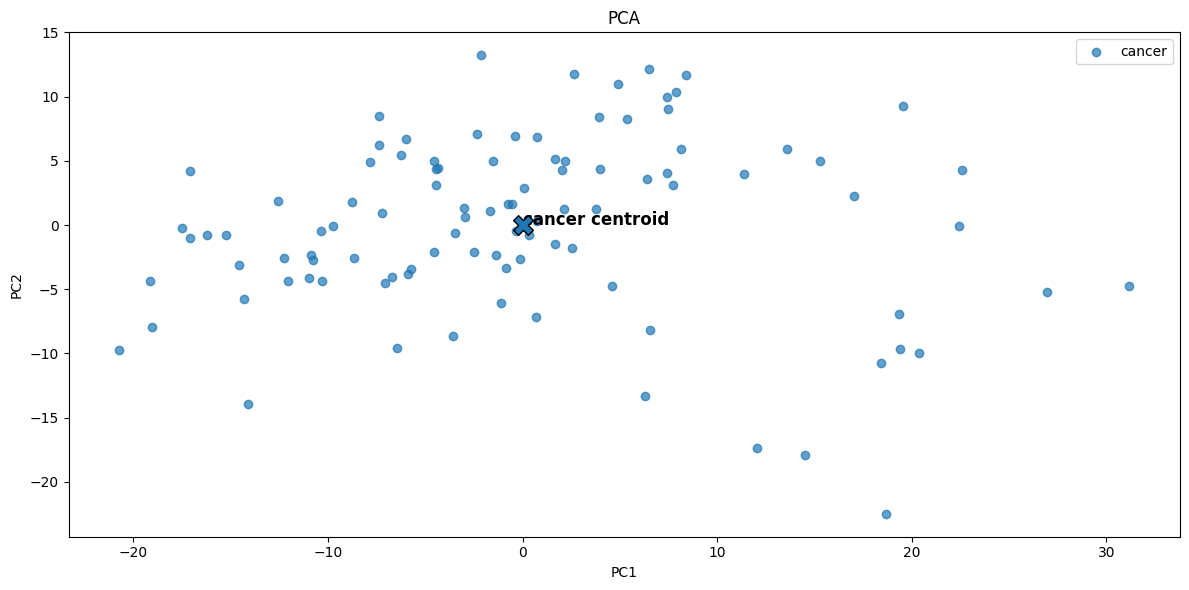

<module 'matplotlib.pyplot' from '/home/zerozed/coding-j/研究/real-time-raman-spectral-classifier-with-gui/.conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import onnxruntime as ort

sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']

print(
    f"Total number of individual spectra in test_spectra: {len(true_labels)}")


# --- Prepare PCA input ONCE using the first model's axis as reference ---
first_model_key = next(iter(models))
first_model_info = models[first_model_key]
onnx_model_instance = MLModel(
    onnx_path=first_model_info["model_path"], meta_path=first_model_info["meta_path"], sess_options=sess_options, providers=providers)

current_common_axis = np.array(onnx_model_instance.metadata["common_axis"])
current_n_features = int(onnx_model_instance.metadata["n_features_in"])

visualizer = RamanVisualizer(spectral_container=test_spectra,
                             labels=true_labels, common_axis=current_common_axis, n_features=current_n_features)
visualizer.pca2d()

# X_pca_input_list = []
# for s_container in test_spectra:
#     if s_container.spectral_data is None or s_container.spectral_data.size == 0:
#         continue
#     for single_spectrum_original_axis in s_container.spectral_data:
#         if single_spectrum_original_axis.ndim != 1:
#             continue
#         if len(s_container.spectral_axis) != current_n_features:
#             interp_spectrum = np.interp(
#                 current_common_axis, s_container.spectral_axis, single_spectrum_original_axis)
#             X_pca_input_list.append(interp_spectrum)
#         else:
#             X_pca_input_list.append(single_spectrum_original_axis)

# if not X_pca_input_list:
#     print("No valid spectral data to process for PCA.")
# else:
#     X_pca_input = np.array(X_pca_input_list)
#     current_true_labels = true_labels[:X_pca_input.shape[0]]

#     print(
#         f"Generating PCA plot for all test data with {X_pca_input.shape[0]} spectra.")

#     # --- Fit PCA ONCE ---
#     pca = PCA(n_components=2)
#     X_pca = pca.fit_transform(X_pca_input)

#     # Save for later use in decision boundary
#     pca_fitted = pca
#     X_pca_input_for_boundary = X_pca_input
#     X_pca_for_boundary = X_pca
#     current_true_labels_for_boundary = current_true_labels

#     # Plot PCA (no decision boundary here, just data)
#     plt.figure(figsize=(12, 6))
#     unique_labels = np.unique(current_true_labels)
#     colors = ['royalblue', 'gold', 'red', 'green', 'purple', 'orange']
#     label_to_color = {label: colors[i % len(
#         colors)] for i, label in enumerate(unique_labels)}
#     for label in unique_labels:
#         idxs = [i for i, l in enumerate(current_true_labels) if l == label]
#         plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], label=label,
#                     color=label_to_color[label], alpha=0.7)

#     # Compute and plot centroids, and line between them
#     centroids = []
#     for label in unique_labels:
#         idxs = [i for i, l in enumerate(current_true_labels) if l == label]
#         centroid = X_pca[idxs].mean(axis=0)
#         centroids.append(centroid)
#         plt.scatter(
#             *centroid, color=label_to_color[label], edgecolor='black', s=200, marker='X', zorder=5)
#         plt.text(centroid[0], centroid[1],
#                  f"{label} centroid", fontsize=12, weight='bold')

#     if len(centroids) == 2:
#         plt.plot([centroids[0][0], centroids[1][0]], [centroids[0][1], centroids[1][1]],
#                  'k--', lw=2, label='Centroid Line')

#     plt.title("PCA of All Test Data")
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

/home/zerozed/coding-j/研究/real-time-raman-spectral-classifier-with-gui/.conda/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-05-22 15:24:33,839 - load_onnx - INFO - Model loaded from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/RF_raman_prostate_model2.onnx and metadata from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/RF_raman_prostate_model2.json



--- Processing Model (Line 0): RF ---
Loading model from: /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/RF_raman_prostate_model2.onnx
Plotting decision boundary for RF...


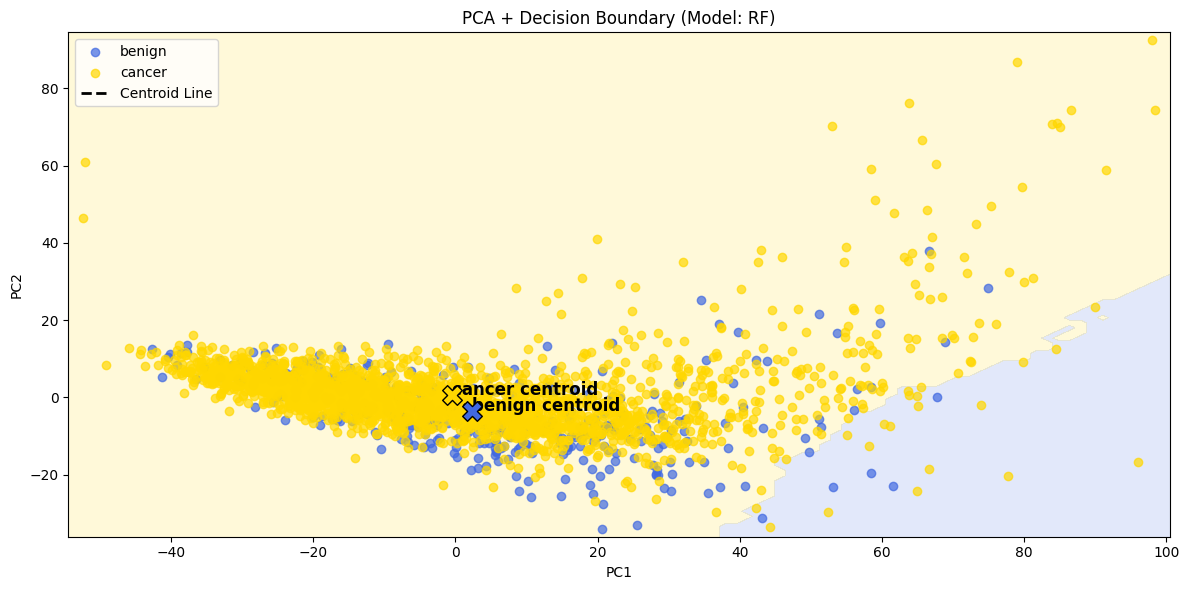

Showing confusion matrix for RF

--- Processing Model (Line 1): SVC-LINEAR ---
Loading model from: /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-LINEAR_raman_prostate_model.onnx


/home/zerozed/coding-j/研究/real-time-raman-spectral-classifier-with-gui/.conda/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-05-22 15:24:58,909 - load_onnx - INFO - Model loaded from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-LINEAR_raman_prostate_model.onnx and metadata from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-LINEAR_raman_prostate_model.json


Plotting decision boundary for SVC-LINEAR...


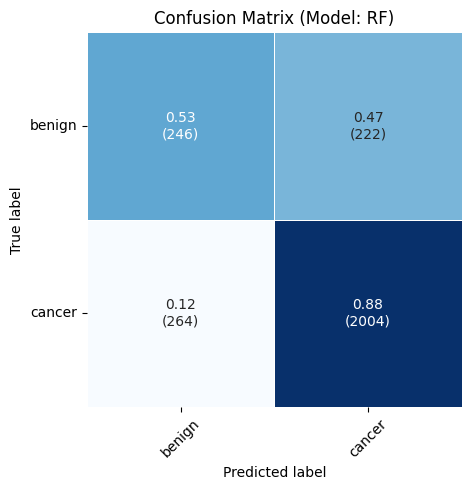

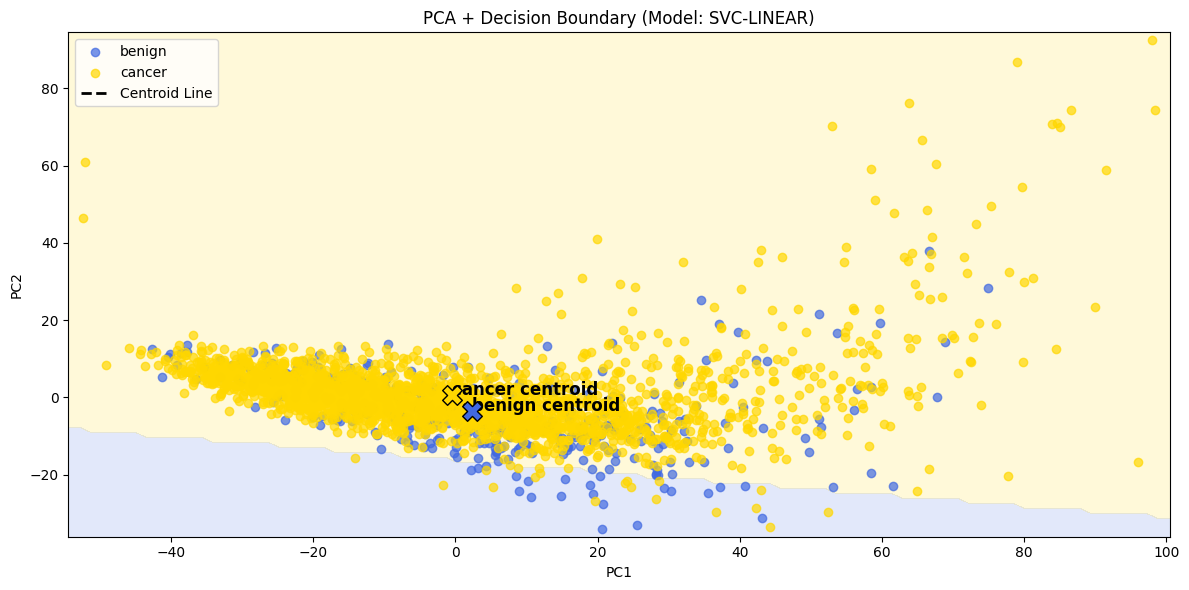

Showing confusion matrix for SVC-LINEAR

--- Processing Model (Line 2): SVC-RBF ---
Loading model from: /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-RBF_raman_prostate_model2.onnx


/home/zerozed/coding-j/研究/real-time-raman-spectral-classifier-with-gui/.conda/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-05-22 15:25:49,700 - load_onnx - INFO - Model loaded from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-RBF_raman_prostate_model2.onnx and metadata from /mnt/j/coding/研究/real-time-raman-spectral-classifier-with-gui/models/SVC-RBF_raman_prostate_model2.json


Plotting decision boundary for SVC-RBF...


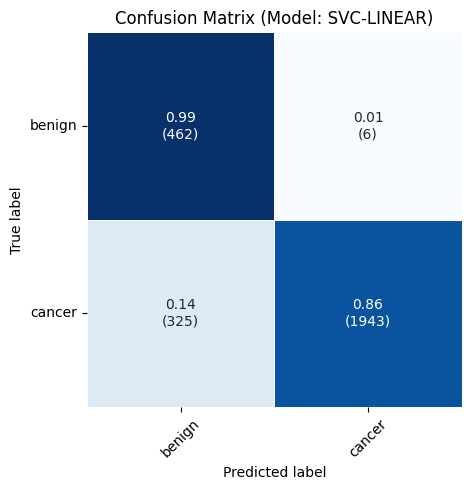

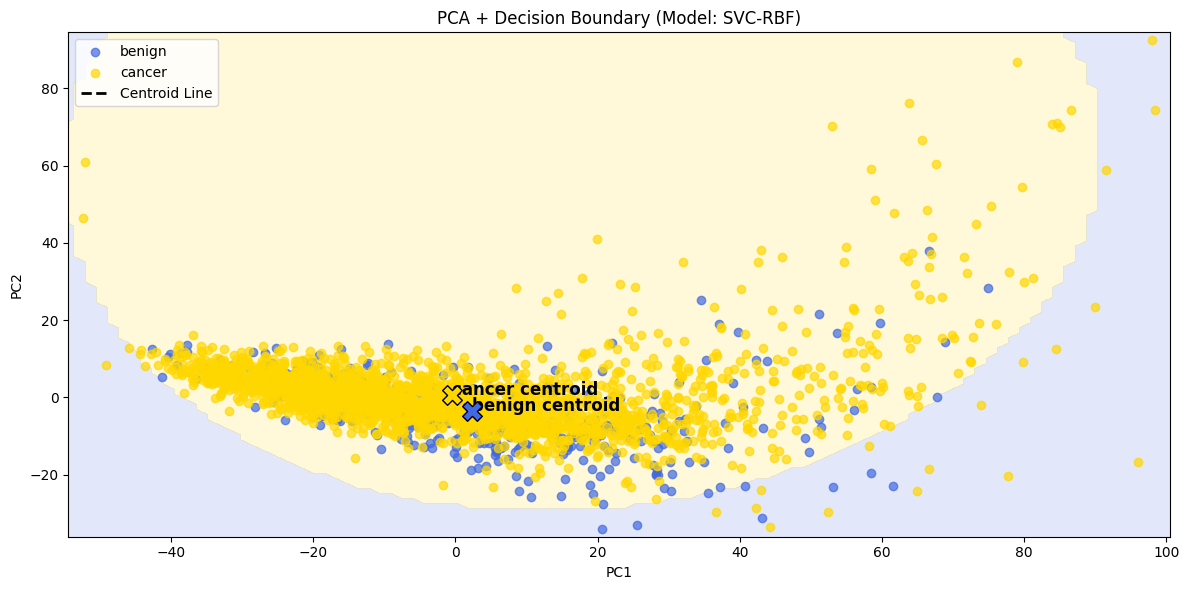

Showing confusion matrix for SVC-RBF

--- PCA, Decision Boundary, and Confusion Matrix Plotting Complete ---


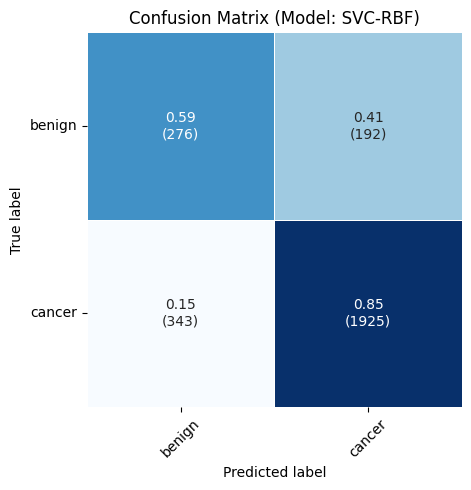

In [12]:
# --- Now show decision boundary and confusion matrix for each model ---
for idx, (model_key, model_info) in enumerate(models.items()):
    print(f"\n--- Processing Model (Line {idx}): {model_key} ---")
    print(f"Loading model from: {model_info['model_path']}")

    onnx_model_instance = MLModel(
        onnx_path=model_info["model_path"], meta_path=model_info["meta_path"], sess_options=sess_options, providers=providers)

    if not getattr(onnx_model_instance, "load_success", False):
        print(
            f"Failed to load model for {model_key}. Skipping decision boundary/confusion matrix.")
        continue

    # --- Decision Boundary in PCA space ---
    print(f"Plotting decision boundary for {model_key}...")
    # 1. Create meshgrid in PCA space
    X_pca = X_pca_for_boundary
    x_min, x_max = X_pca[:, 0].min() - 2, X_pca[:, 0].max() + 2
    y_min, y_max = X_pca[:, 1].min() - 2, X_pca[:, 1].max() + 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 2. Inverse transform to original feature space
    X_grid_original = pca_fitted.inverse_transform(grid_points)

    # 3. Predict using ONNX model (expects list of arrays)
    # If your MLModel expects a list of containers, you may need to wrap X_grid_original accordingly.
    # Here, we assume it accepts a numpy array directly.
    y_grid_pred = onnx_model_instance.predict_numpy(
        X_grid_original, class_labels=labels)
    y_grid_pred = np.array(y_grid_pred).reshape(xx.shape)

    # 4. Plot decision boundary with PCA scatter
    label_to_int = {label: i for i, label in enumerate(labels)}
    y_grid_pred_int = np.vectorize(label_to_int.get)(y_grid_pred)
    plt.figure(figsize=(12, 6))
    plt.contourf(xx, yy, y_grid_pred_int, alpha=0.15, levels=len(
        labels)-1, colors=[label_to_color[l] for l in labels])
    for label in np.unique(current_true_labels_for_boundary):
        idxs = [i for i, l in enumerate(
            current_true_labels_for_boundary) if l == label]
        plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], label=label,
                    color=label_to_color[label], alpha=0.7)
    # Centroids and line
    centroids = []
    for label in np.unique(current_true_labels_for_boundary):
        idxs = [i for i, l in enumerate(
            current_true_labels_for_boundary) if l == label]
        centroid = X_pca[idxs].mean(axis=0)
        centroids.append(centroid)
        plt.scatter(
            *centroid, color=label_to_color[label], edgecolor='black', s=200, marker='X', zorder=5)
        plt.text(centroid[0], centroid[1],
                 f"{label} centroid", fontsize=12, weight='bold')
    if len(centroids) == 2:
        plt.plot([centroids[0][0], centroids[1][0]], [centroids[0][1], centroids[1][1]],
                 'k--', lw=2, label='Centroid Line')
    plt.title(f"PCA + Decision Boundary (Model: {model_key})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Confusion Matrix Heatmap ---
    pred_result = onnx_model_instance.predict(
        test_spectra, class_labels=labels)
    y_pred = pred_result["y_pred"]
    if len(y_pred) != len(true_labels):
        print(
            f"Warning: y_pred and true_labels length mismatch for {model_key}. Aligning to shortest.")
        min_len = min(len(y_pred), len(true_labels))
        y_pred = y_pred[:min_len]
        y_true = true_labels[:min_len]
    else:
        y_true = true_labels

    print(f"Showing confusion matrix for {model_key}")
    visualizer.confusion_matrix_heatmap(
        y_true=y_true,
        y_pred=y_pred,
        class_labels=labels,
        title=f"Confusion Matrix (Model: {model_key})",
        figsize=(6, 5),
        normalize=True,
        show_counts=True,
        show_heatmap=True,
        fmt="s"
    )

    input("Press Enter to continue to the next model...")

print("\n--- PCA, Decision Boundary, and Confusion Matrix Plotting Complete ---")